In [2]:
!pip3 install edm


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
from edm import report
import os
import time
import gc
import random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.preprocessing import text, sequence
import torch 
from torch import nn
from torch.utils import data
from torch.nn import functional as F

Using TensorFlow backend.


In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [5]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 


IndexError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_data = pd.read_csv('/content/gdrive/My Drive/data-science/data/data/train.csv')
test_data = pd.read_csv('/content/gdrive/My Drive/data-science/data/data/test.csv')

In [0]:
crawl_embeddings = '/content/gdrive/My Drive/data-science/data/data/crawl-300d-2M.vec'
glove_embeddings = '/content/gdrive/My Drive/data-science/data/data/glove.840B.300d.txt'
models = 2
lstm_layers = 128
dense_layers = 4 * lstm_layers
max_len = 220

MAX_LEN, max_features = None, None

In [5]:
train_data.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4


In [6]:
test_data.head(2)

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...


In [7]:
train_data.isnull().sum()

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

In [8]:
test_data.isnull().sum()

id              0
comment_text    0
dtype: int64

In [9]:
train_data['comment_text'].value_counts().head()

Well said.    184
No.           160
Exactly.      132
Yes.          127
Thank you.    120
Name: comment_text, dtype: int64

In [10]:
print('% unique comments:', (train_data['comment_text'].nunique()/ train_data['comment_text'].shape[0])*100)

% unique comments: 98.66744160534198


In [11]:
train_comments = set(train_data['comment_text'].values)
test_comments = set(test_data['comment_text'].values)

#1170 unique comments from train data are in test data
len(train_comments.intersection(test_comments)), len(test_data.loc[test_data['comment_text'].isin(list(train_comments.intersection(test_comments)))])

(1170, 1522)

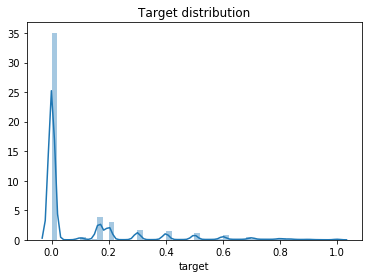

In [12]:
sns.distplot(train_data['target']).set_title('Target distribution')
plt.show()

In [0]:
train_data = train_data.reindex(sorted(train_data.columns), axis=1)

In [14]:
train_data.head()

,article_id,asian,atheist,bisexual,black,buddhist,christian,comment_text,created_date,disagree,female,funny,heterosexual,hindu,homosexual_gay_or_lesbian,id,identity_annotator_count,identity_attack,insult,intellectual_or_learning_disability,jewish,latino,likes,male,muslim,obscene,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,parent_id,physical_disability,psychiatric_or_mental_illness,publication_id,rating,sad,severe_toxicity,sexual_explicit,target,threat,toxicity_annotator_count,transgender,white,wow
0,2006,NaN,NaN,NaN,NaN,NaN,NaN,"This is so cool. It's like, 'would you want yo...",2015-09-29 10:50:41.987077+00,0,NaN,0,NaN,NaN,NaN,59848,0,0.000000,0.00000,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,rejected,0,0.000000,0.0,0.000000,0.0,4,NaN,NaN,0
1,2006,NaN,NaN,NaN,NaN,NaN,NaN,Thank you!! This would make my life a lot less...,2015-09-29 10:50:42.870083+00,0,NaN,0,NaN,NaN,NaN,59849,0,0.000000,0.00000,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,rejected,0,0.000000,0.0,0.000000,0.0,4,NaN,NaN,0
2,2006,NaN,NaN,NaN,NaN,NaN,NaN,This is such an urgent design problem; kudos t...,2015-09-29 10:50:45.222647+00,0,NaN,0,NaN,NaN,NaN,59852,0,0.000000,0.00000,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,rejected,0,0.000000,0.0,0.000000,0.0,4,NaN,NaN,0
3,2006,NaN,NaN,NaN,NaN,NaN,NaN,Is this something I'll be able to install on m...,2015-09-29 10:50:47.601894+00,0,NaN,0,NaN,NaN,NaN,59855,0,0.000000,0.00000,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,rejected,0,0.000000,0.0,0.000000,0.0,4,NaN,NaN,0
4,2006,0.0,0.0,0.0,0.0,0.0,0.0,haha you guys are a bunch of losers.,2015-09-29 10:50:48.488476+00,0,0.0,0,0.0,0.0,0.0,59856,4,0.021277,0.87234,0.25,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2,rejected,0,0.021277,0.0,0.893617,0.0,47,0.0,0.0,0


In [0]:
# Mutating date column and calculate counts and the means to visialize the trend
train_data['created_date'] = pd.to_datetime(train_data['created_date']).values.astype('datetime64[M]')
train_data['created_year'] = pd.to_datetime(train_data['created_date']).values.astype('datetime64[Y]')
counts = train_data.groupby(['created_date'])['target'].mean().sort_index().reset_index()
means = train_data.groupby(['created_date'])['target'].count().sort_index().reset_index()

In [16]:
train_data.head()

,article_id,asian,atheist,bisexual,black,buddhist,christian,comment_text,created_date,disagree,female,funny,heterosexual,hindu,homosexual_gay_or_lesbian,id,identity_annotator_count,identity_attack,insult,intellectual_or_learning_disability,jewish,latino,likes,male,muslim,obscene,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,parent_id,physical_disability,psychiatric_or_mental_illness,publication_id,rating,sad,severe_toxicity,sexual_explicit,target,threat,toxicity_annotator_count,transgender,white,wow,created_year
0,2006,NaN,NaN,NaN,NaN,NaN,NaN,"This is so cool. It's like, 'would you want yo...",2015-09-01,0,NaN,0,NaN,NaN,NaN,59848,0,0.000000,0.00000,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,rejected,0,0.000000,0.0,0.000000,0.0,4,NaN,NaN,0,2015-01-01
1,2006,NaN,NaN,NaN,NaN,NaN,NaN,Thank you!! This would make my life a lot less...,2015-09-01,0,NaN,0,NaN,NaN,NaN,59849,0,0.000000,0.00000,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,rejected,0,0.000000,0.0,0.000000,0.0,4,NaN,NaN,0,2015-01-01
2,2006,NaN,NaN,NaN,NaN,NaN,NaN,This is such an urgent design problem; kudos t...,2015-09-01,0,NaN,0,NaN,NaN,NaN,59852,0,0.000000,0.00000,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,rejected,0,0.000000,0.0,0.000000,0.0,4,NaN,NaN,0,2015-01-01
3,2006,NaN,NaN,NaN,NaN,NaN,NaN,Is this something I'll be able to install on m...,2015-09-01,0,NaN,0,NaN,NaN,NaN,59855,0,0.000000,0.00000,NaN,NaN,NaN,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,rejected,0,0.000000,0.0,0.000000,0.0,4,NaN,NaN,0,2015-01-01
4,2006,0.0,0.0,0.0,0.0,0.0,0.0,haha you guys are a bunch of losers.,2015-09-01,0,0.0,0,0.0,0.0,0.0,59856,4,0.021277,0.87234,0.25,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,2,rejected,0,0.021277,0.0,0.893617,0.0,47,0.0,0.0,0,2015-01-01


In [17]:
counts.head(2)

,created_date,target
0,2015-09-01,0.064255
1,2015-10-01,0.067268


In [18]:
means.head(2)

,created_date,target
0,2015-09-01,324
1,2015-10-01,260


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


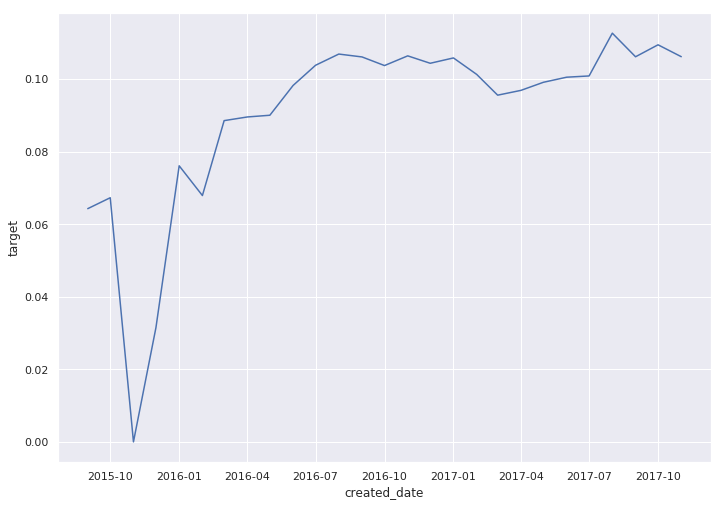

In [19]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x='created_date', y='target', data=counts)
plt.show()

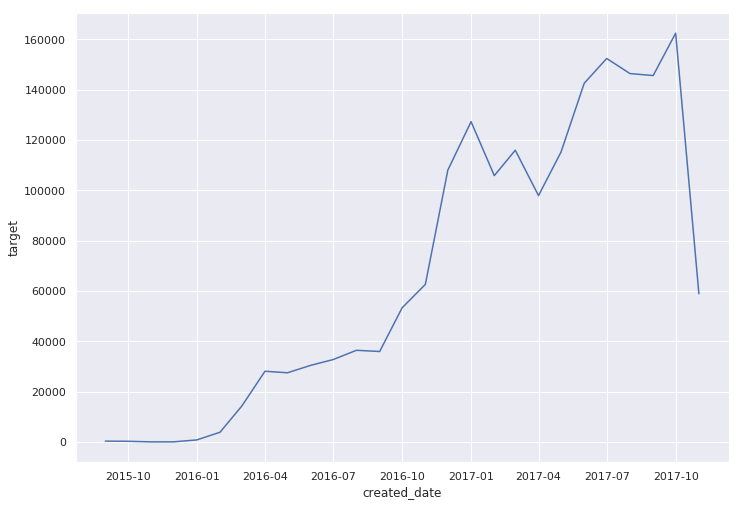

In [20]:
#Counts of comments through the years
sns.lineplot(x='created_date', y='target', data=means)
plt.show()

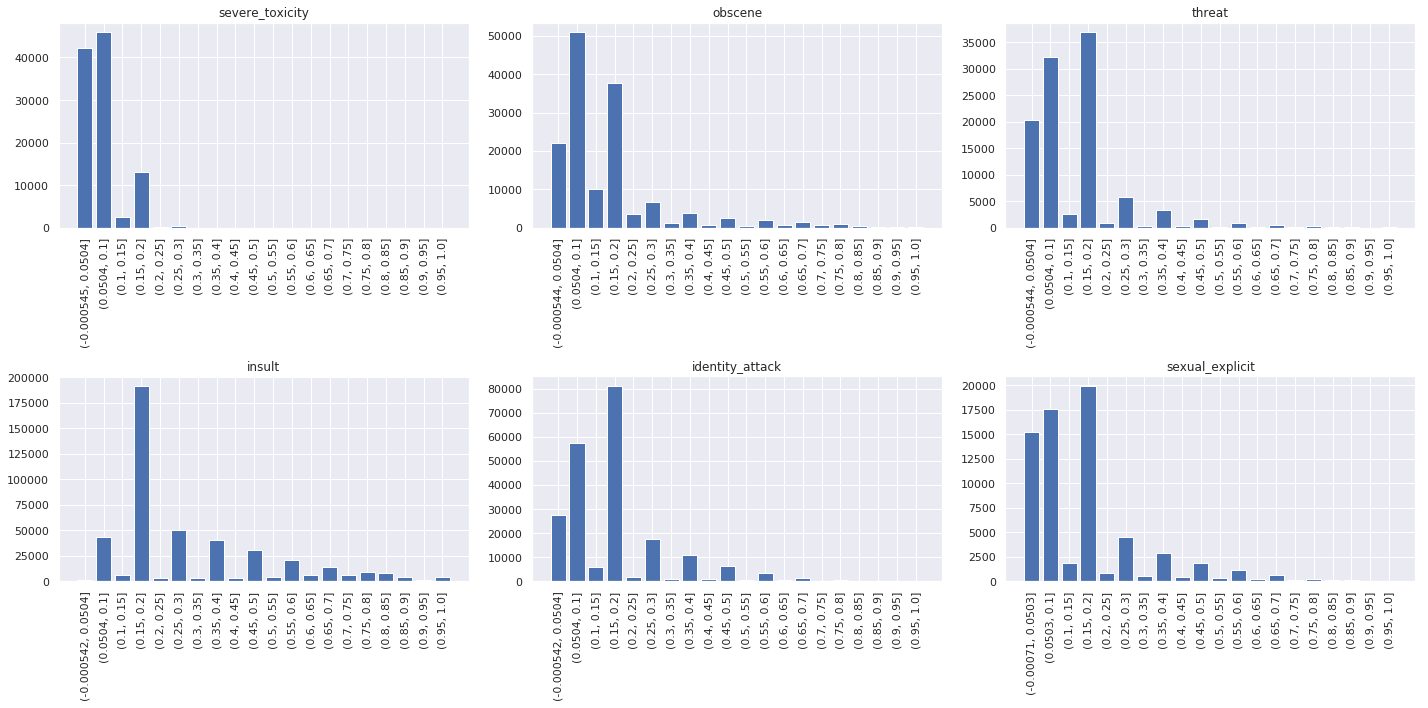

In [21]:
fig = plt.figure(figsize=(20,10))
i=0
fig.subplots_adjust(hspace=.5)
for col in ['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']:
    i+=1
    df = train_data.loc[train_data[col] > 0]
    hist_df = pd.cut(df[col], 20).value_counts().sort_index().reset_index().rename(columns={'index': 'bins'})
    plt.subplot(2, 3, i)
    plt.bar(hist_df.bins.astype(str), hist_df[col])
    plt.xticks(rotation=90)
    plt.title(col)
plt.tight_layout()
plt.show()

In [0]:
df = train_data.sample(frac=0.02)
sents = df["comment_text"].fillna("_##_").values
labels = df["target"].values

In [0]:
# print(report.get_difficulty_report(sents, labels))

In [0]:
def generate_word_cloud(data, title = None):
    plt.figure(figsize=(20,20))
    text=data.comment_text.values
    wc= WordCloud(max_words=5000,stopwords=set(STOPWORDS))
    wc.generate(" ".join(text))
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.title(title, fontsize=19)
    plt.imshow(wc.recolor(colormap= 'magma' , random_state=19), alpha=1)

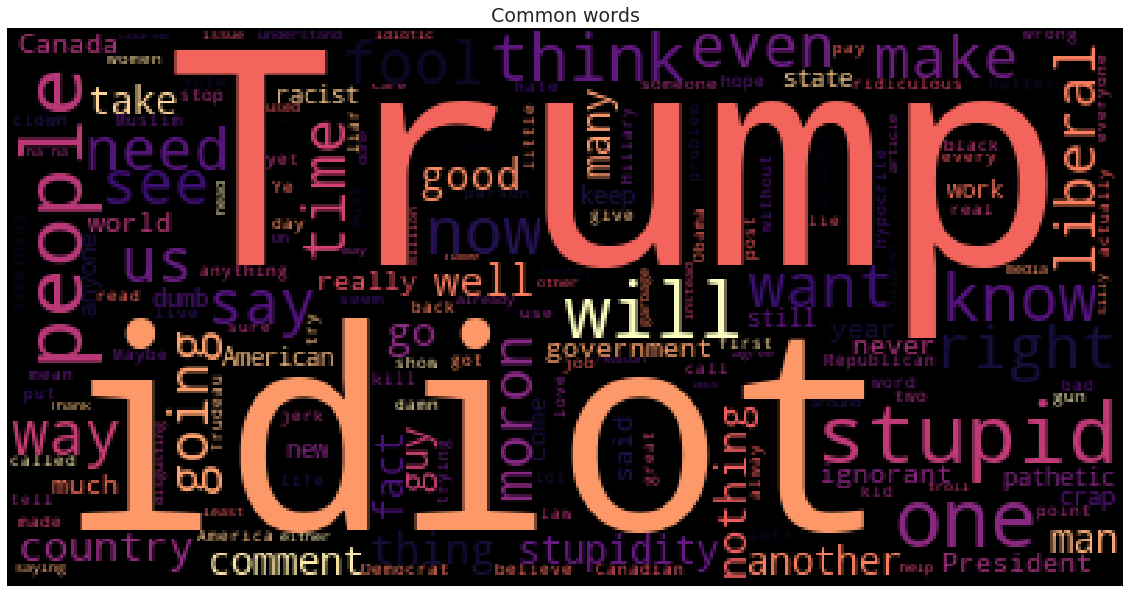

In [25]:
data=train_data[train_data.target>0.75]
generate_word_cloud(data, title = "Common words")

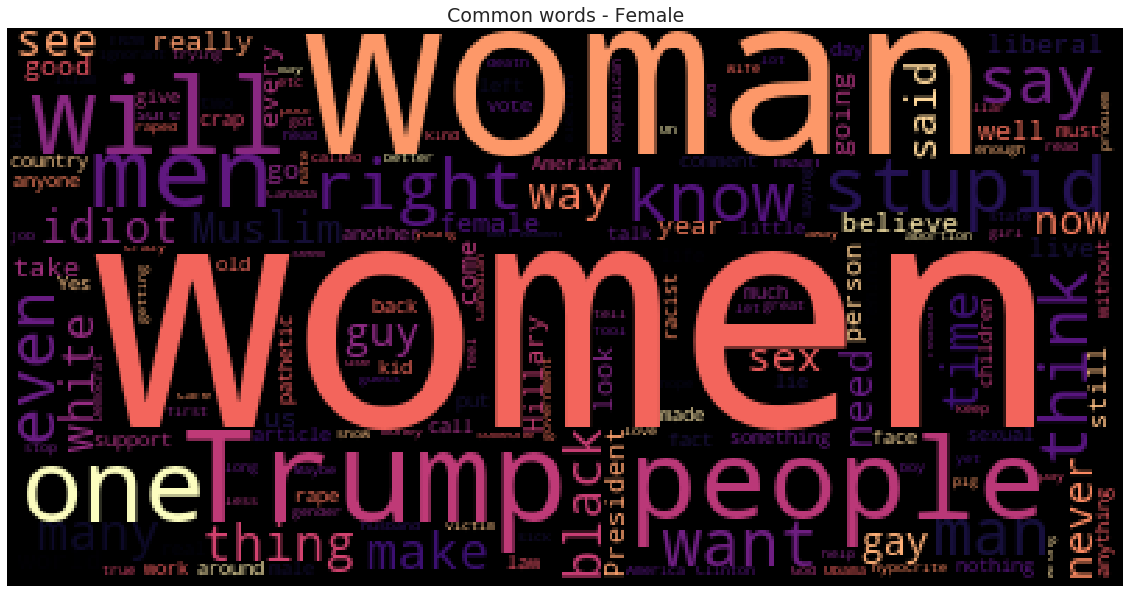

In [26]:
female_data = train_data[(train_data['female'] >0.75)&(train_data['target']>0.75)]
generate_word_cloud(female_data,title = "Common words - Female")

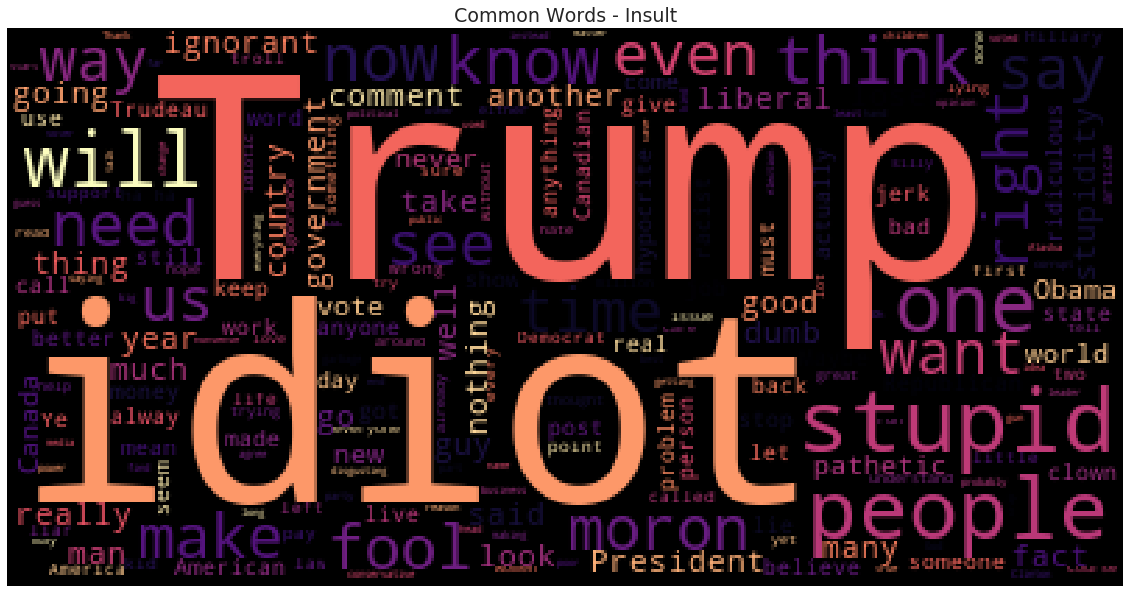

In [27]:
insult_data = train_data[(train_data['insult'] >0.75)&(train_data['target']>0.75)]
generate_word_cloud(insult_data, title = "Common Words - Insult")

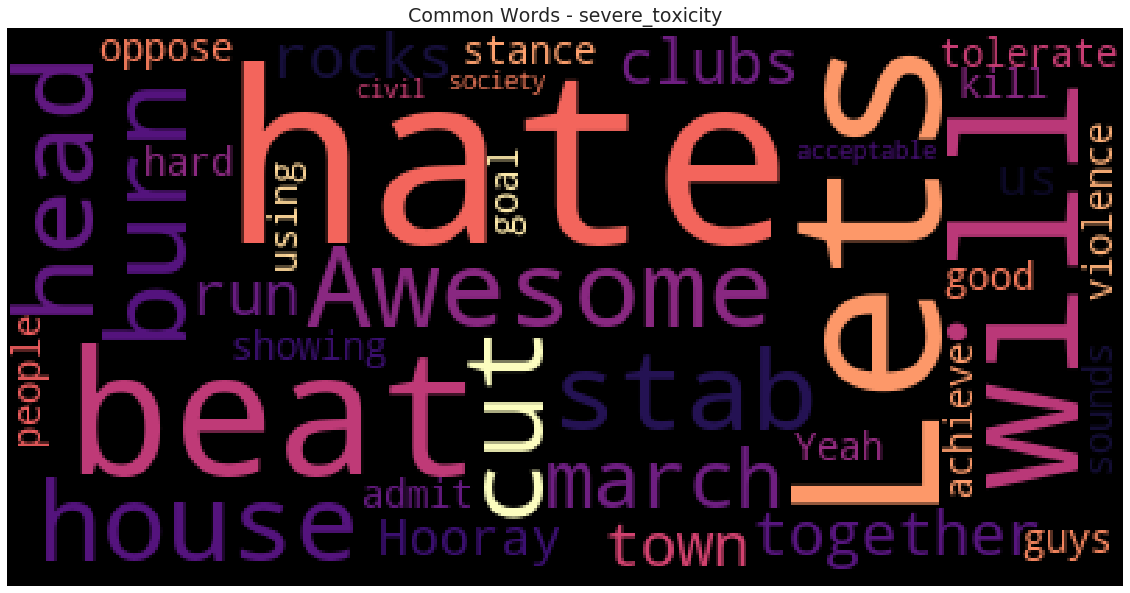

In [28]:
severe_toxicity_data = train_data[(train_data['severe_toxicity'] >0.75)&(train_data['target']>0.75)]
generate_word_cloud(severe_toxicity_data, title = "Common Words - severe_toxicity")

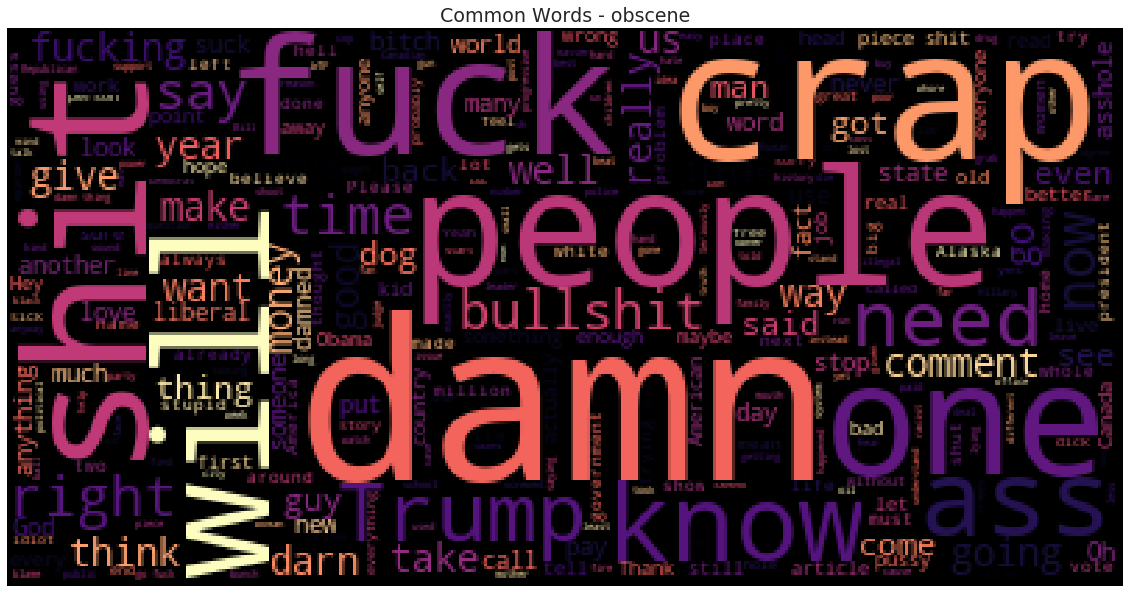

In [29]:
obscene_data = train_data[(train_data['obscene'] >0.75)&(train_data['target']>0.75)]
generate_word_cloud(obscene_data, title = "Common Words - obscene")

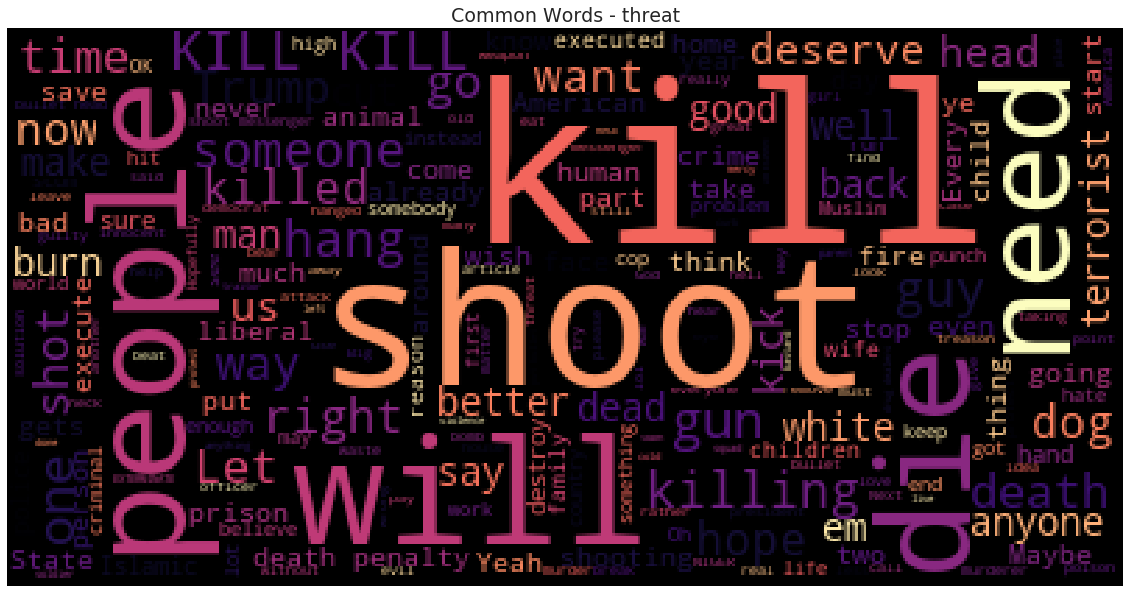

In [30]:
threat_data = train_data[(train_data['threat'] >0.75)&(train_data['target']>0.75)]
generate_word_cloud(threat_data, title = "Common Words - threat")

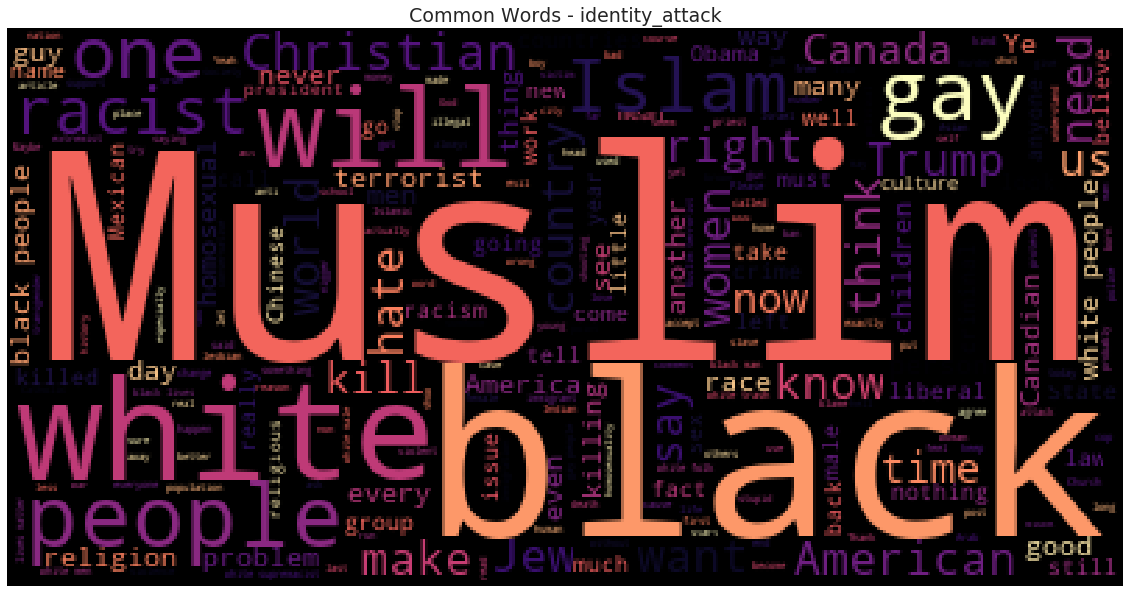

In [31]:
identity_attack_data = train_data[(train_data['identity_attack'] >0.75)&(train_data['target']>0.75)]
generate_word_cloud(identity_attack_data, title = "Common Words - identity_attack")

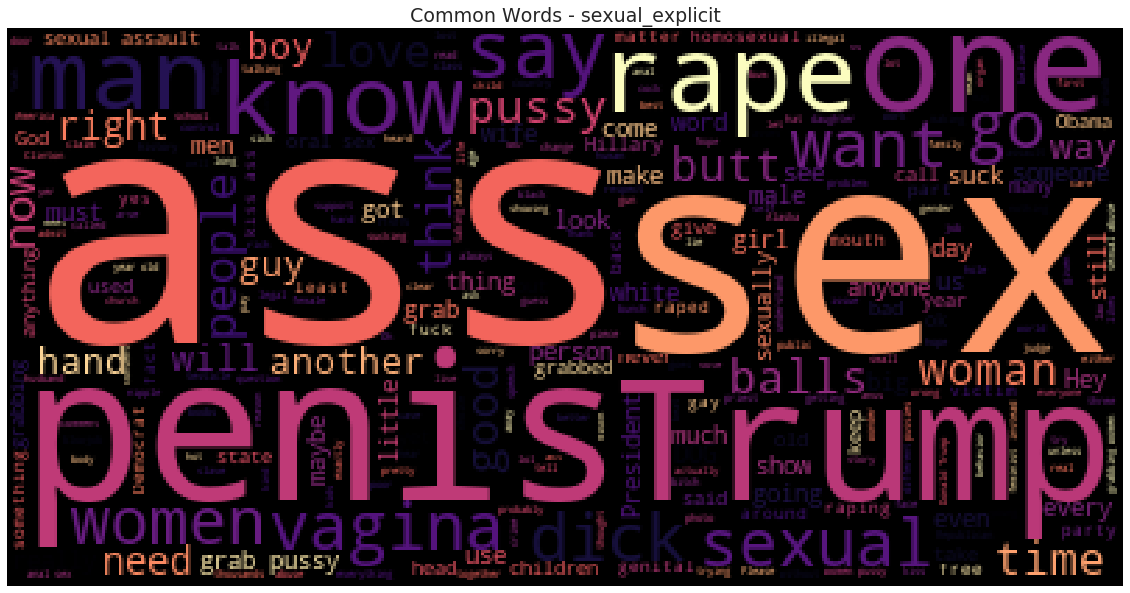

In [32]:
sexual_explicit_data = train_data[(train_data['sexual_explicit'] >0.75)&(train_data['target']>0.75)]
generate_word_cloud(sexual_explicit_data, title = "Common Words - sexual_explicit")

In [0]:
def seed_everything(seed=19):
    random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [0]:
def remove_spl_characters(data):
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [0]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x
    

class LSTMNeuralNet(nn.Module):
    def __init__(self, embedding_matrix, num_aux_targets):
#         super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
        self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

In [0]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def train_model(model, train, test, loss_fn, output_dim, lr=0.001,
                batch_size=512, n_epochs=4,
                enable_checkpoint_ensemble=True):
    param_lrs = [{'params': param, 'lr': lr} for param in model.parameters()]
    optimizer = torch.optim.Adam(param_lrs, lr=lr)

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
    all_test_preds = []
    checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
    
    for epoch in range(n_epochs):
        start_time = time.time()
        
        scheduler.step()
        
        model.train()
        avg_loss = 0.
        
        for data in tqdm(train_loader, disable=False):
            x_batch = data[:-1]
            y_batch = data[-1]

            y_pred = model(*x_batch)            
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
            
        model.eval()
        test_preds = np.zeros((len(test), output_dim))
    
        for i, x_batch in enumerate(test_loader):
            y_pred = sigmoid(model(*x_batch).detach().cpu().numpy())

            test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred

        all_test_preds.append(test_preds)
        elapsed_time = time.time() - start_time
        print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
              epoch + 1, n_epochs, avg_loss, elapsed_time))

    if enable_checkpoint_ensemble:
        test_preds = np.average(all_test_preds, weights=checkpoint_weights, axis=0)    
    else:
        test_preds = all_test_preds[-1]
        
    return test_preds

In [0]:
x_train = remove_spl_characters(train_data['comment_text'])
y_train = np.where(train_data['target'] >= 0.5, 1, 0)
y_aux_train = train_data[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = remove_spl_characters(test_data['comment_text'])

In [0]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

In [51]:
max_features = max_features or len(tokenizer.word_index) + 1
max_features

327576

In [58]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, crawl_embeddings)
print('n unknown words (crawl): ', len(unknown_words_crawl))


n unknown words (crawl):  174141


In [1]:
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, glove_embeddings)
print('n unknown words (glove): ', len(unknown_words_glove))

NameError: ignored